## **Validation (1D)**

### **Set Environment**

In [ ]:
from lib.QuantumCalculator import LaplacianEVProcessor1D, InnerProductProcessor
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ionq import IonQProvider
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# # IonQ Simulator
# import os
# os.environ['IONQ_API_KEY'] = 'your api key'
# my_api_key = os.getenv("IONQ_API_KEY")
provider = IonQProvider(my_api_key)
simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
simulator_backend.set_options(noise_model="ideal")

# # IBM Hardware
# QiskitRuntimeService.delete_account()
# QiskitRuntimeService.save_account(instance = 'your crn', token = 'your token', set_as_default=True, overwrite=True)
hardware_backend = QiskitRuntimeService().least_busy()
print(hardware_backend.name)

ibm_yonsei


### **Initialize Sampler**

In [2]:
grid_num = 16
one_dim_grid_num = int(np.sqrt(grid_num))
num_shots = 2**19

options_sampler = SamplerOptions()
options_sampler.default_shots = num_shots
sampler = Sampler(mode = hardware_backend, options = options_sampler)

### **Design Ansatz**

Number of Parameters: 16


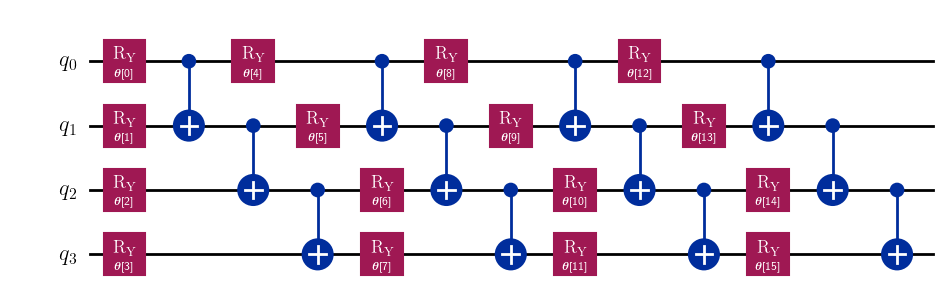

In [3]:
num_qubits = int(np.log2(grid_num))
num_qubits1D = int(num_qubits / 2)
ansatz_depth = 4
param_num = num_qubits * ansatz_depth
parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)

def create_parameterized_ansatz(num_qubits, ansatz_depth, parameters):
    qc = QuantumCircuit(num_qubits)
    for depth in range (ansatz_depth):
        for i in range(0,num_qubits):
            qc.ry(parameters[i + depth * (num_qubits)],  i)
        for i in range (0, num_qubits-1):
            qc.cx( i,  (i+1))
    return qc

psi_param_circuit = create_parameterized_ansatz(num_qubits, ansatz_depth, parameters)
print(f"Number of Parameters: {param_num}")
psi_param_circuit.draw('mpl', fold = -1)

### **Classical Functions**

In [4]:
I = np.array([[1,0],
             [0,1]], dtype = complex)

X = np.array([[0,1],
             [1,0]], dtype = complex)
classical_CNOT = np.array([[1,0,0,0],
                          [0,1,0,0],
                          [0,0,0,1],
                          [0,0,1,0]], dtype=complex)
def laplacian_matrix(n, boundary_condition):
    L = np.zeros((n, n))
    for i in range (n):
        L[i,i] = -2
    for i in range(n - 1):
        L[i + 1, i] = 1
    for i in range(n - 1):
        L[i, i+1] = 1
    if boundary_condition == "Neumann":
        L[0,0] = -1
        L[n-1, n-1] = -1
    elif boundary_condition == "Periodic":        
        L[n - 1, 0] = 1
        L[0, n - 1] = 1
    return L
def CNOT_matrix(num_qubits, control_index):
    if control_index != 0:
        matrix = np.array([[1,0],[0,1]], dtype = complex)
    else:
        matrix = 1
    for i in range (1, control_index):
        matrix = np.kron(matrix, I)
    matrix = np.kron(matrix, classical_CNOT)
    for i in range (control_index+2, num_qubits):
        matrix = np.kron(matrix, I)
    return matrix
def classical_RZGate(theta):
    return np.array([[np.exp(-1j * theta/2), 0],
                    [0, np.exp(1j * theta/2)]], dtype = complex)

def classical_RYGate(theta):
    return np.array([[np.cos(theta/2), -np.sin(theta/2)],
                    [np.sin(theta/2), np.cos(theta/2)]], dtype = complex)

def classical_RYGate_nqubits(params, num_qubits):
    RYGate = classical_RYGate(params[0])
    for qubit_num in range (num_qubits-1):
        RYGate = np.kron(RYGate, classical_RYGate(params[qubit_num+1]))
    return RYGate
        
def classical_RZGate_nqubits(params, num_qubits):
    RZGate = classical_RZGate(params[0])
    for qubit_num in range (num_qubits-1):
        RZGate = np.kron(RZGate, classical_RZGate(params[qubit_num+1]))
    return RZGate

def bit_reverse_index(i, num_bits):
    rev = 0
    for _ in range(num_bits):
        rev = (rev << 1) | (i & 1)
        i >>= 1
    return rev

def bit_reverse_statevector(state, num_qubits):
    dim = 2 ** num_qubits
    new_state = np.zeros(dim, dtype=complex)
    for i in range(dim):
        new_state[bit_reverse_index(i, num_qubits)] = state[i]
    return new_state


def make_classical_psi(num_qubits, ansatz_depth, params):
    # Make the first layer of RY & RZ
    psi_list = []
    for qubit in range(0,num_qubits):
        psi = np.array([1,0], dtype = complex)
        psi = classical_RYGate(params[qubit]) @ psi.T
        psi_list.append(psi)
    psi = psi_list[0]
    for psis in psi_list[1:]:
        psi = np.kron(psi, psis)
    # First CNOT barrier
    for qubit in range (0, num_qubits - 1):
        psi = CNOT_matrix(num_qubits, qubit) @ psi
    
    for depth in range (1, ansatz_depth):
        psi = classical_RYGate_nqubits(params = [params[i] for i in range ((num_qubits)*depth , (num_qubits)*depth + num_qubits)], num_qubits=num_qubits) @ psi
        for qubit in range (0, num_qubits-1):
            psi = CNOT_matrix(num_qubits, qubit) @ psi
    return bit_reverse_statevector(psi, num_qubits)

### **Periodic Laplacian**

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


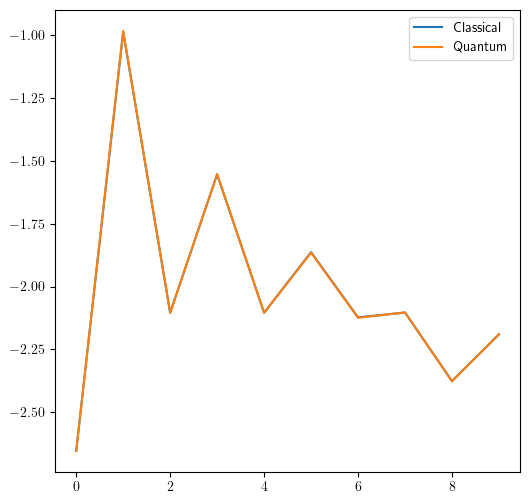

In [ ]:
params_list = []
cevs_list = []
A = laplacian_matrix(grid_num, "Periodic")
for i in range (10):
    params = 4 * np.pi * np.random.rand(param_num)
    params_list.append(params)
    cpsi = make_classical_psi(num_qubits, ansatz_depth, params)
    cevs_list.append(cpsi @ A @ cpsi)
    
ansatz_list = [psi_param_circuit] * 10
boundary_condition_list = ['P'] * 10

processor = LaplacianEVProcessor1D(
    params_list=params_list,
    ansatz_list=ansatz_list,
    boundary_condition_list=boundary_condition_list,
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

circuits = processor.make_circuits()

transpiled = processor.transpile(circuits, optimization_level = 1)

counts = processor.simulator_execute(transpiled)

qevs_list = processor.make_evs(counts)

plt.figure(figsize = (6,6))
plt.plot(cevs_list, label = "Classical")
plt.plot(qevs_list, label = "Quantum")
plt.legend()
plt.show()

### **Dirichlet Laplacian**

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


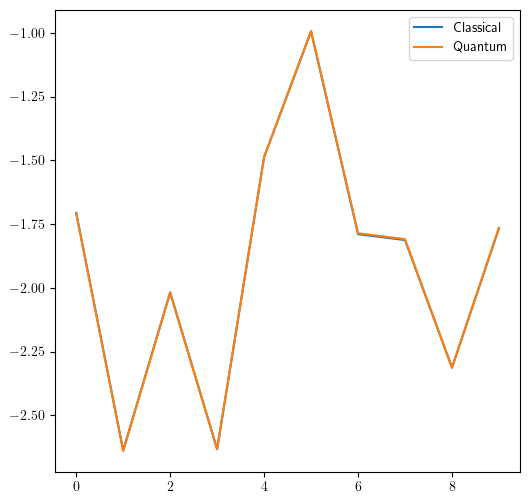

In [ ]:
params_list = []
cevs_list = []
A = laplacian_matrix(grid_num, "Dirichlet")
for i in range (10):
    params = 4 * np.pi * np.random.rand(param_num)
    params_list.append(params)
    cpsi = make_classical_psi(num_qubits, ansatz_depth, params)
    cevs_list.append(cpsi @ A @ cpsi)
    
ansatz_list = [psi_param_circuit] * 10
boundary_condition_list = ['D'] * 10

processor = LaplacianEVProcessor1D(
    params_list=params_list,
    ansatz_list=ansatz_list,
    boundary_condition_list=boundary_condition_list,
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

circuits = processor.make_circuits()

transpiled = processor.transpile(circuits, optimization_level = 1)

counts = processor.simulator_execute(transpiled)

qevs_list = processor.make_evs(counts)

plt.figure(figsize = (6,6))
plt.plot(cevs_list, label = "Classical")
plt.plot(qevs_list, label = "Quantum")
plt.legend()
plt.show()

### **Neumann Laplacian**

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


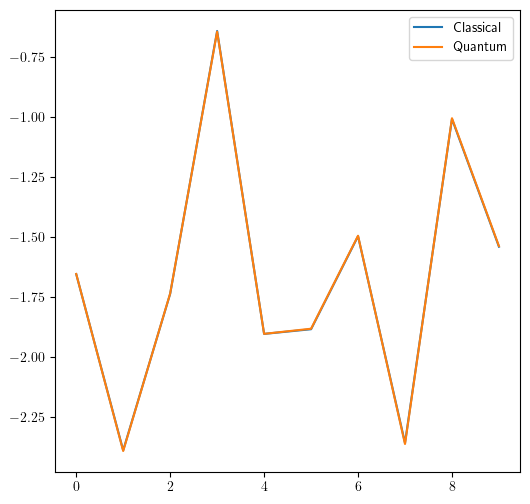

In [ ]:
params_list = []
cevs_list = []
A = laplacian_matrix(grid_num, "Neumann")
for i in range (10):
    params = 4 * np.pi * np.random.rand(param_num)
    params_list.append(params)
    cpsi = make_classical_psi(num_qubits, ansatz_depth, params)
    cevs_list.append(cpsi @ A @ cpsi)
    
ansatz_list = [psi_param_circuit] * 10
boundary_condition_list = ['N'] * 10

processor = LaplacianEVProcessor1D(
    params_list=params_list,
    ansatz_list=ansatz_list,
    boundary_condition_list=boundary_condition_list,
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

circuits = processor.make_circuits()

transpiled = processor.transpile(circuits, optimization_level = 1)

counts = processor.simulator_execute(transpiled)

qevs_list = processor.make_evs(counts)

plt.figure(figsize = (6,6))
plt.plot(cevs_list, label = "Classical")
plt.plot(qevs_list, label = "Quantum")
plt.legend()
plt.show()

### **Numerator Laplacian**

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


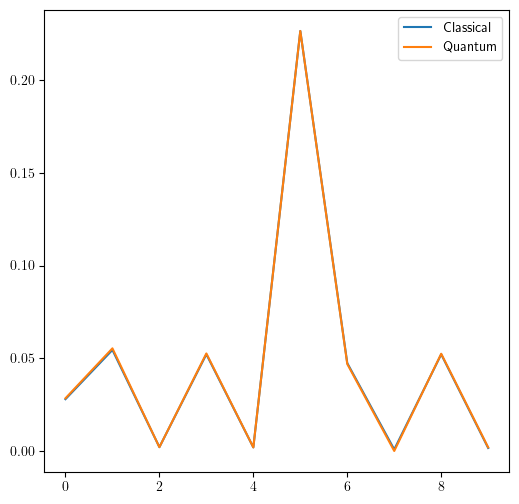

In [6]:
params_list = []
cevs_list = []

f = np.array([np.sin(2 * np.pi * i / grid_num) for i in range (grid_num)])
f_normalized = f / np.linalg.norm(f)
numerator_list = [f_normalized] * 10

for i in range (10):
    params = 4 * np.pi * np.random.rand(param_num)
    params_list.append(params)
    cpsi = make_classical_psi(num_qubits, ansatz_depth, params)
    cevs_list.append(np.inner(cpsi, f_normalized)**2)
    
ansatz_list = [psi_param_circuit] * 10

processor = InnerProductProcessor(
    params_list=params_list,
    ansatz_list=ansatz_list,
    numerator_list = numerator_list,
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

circuits = processor.make_circuits()

transpiled = processor.transpile(circuits, optimization_level = 1)

counts = processor.simulator_execute(transpiled)

qevs_list = processor.make_evs(counts)

plt.figure(figsize = (6,6))
plt.plot(cevs_list, label = "Classical")
plt.plot(qevs_list, label = "Quantum")
plt.legend()
plt.show()